In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 56.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r "/content/drive/MyDrive/DataMining/Cityscapes" "/content/Cityscapes"

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torch

# Mask dönüşümü: sadece seçili sınıfları kullan ve diğerlerini arka plan olarak ayarla
def mask_transform(mask):
    mask = mask.resize((256, 256), resample=Image.NEAREST)
    mask = np.array(mask)
    # Sınıfları yeniden etiketle: sadece seçili sınıflar tutuluyor
    new_mask = np.zeros_like(mask)
    class_mapping = {7: 1, 11: 2, 21: 3, 8: 4, 26: 5}  # Seçili sınıf eşleştirmesi

    for original_label, new_label in class_mapping.items():
        new_mask[mask == original_label] = new_label

    return torch.tensor(new_mask, dtype=torch.long)

# Cityscapes Dataset Sınıfı
class CityscapesCustomDataset(Dataset):
    def __init__(self, image_root_dir, mask_root_dir, transform_image=None, transform_mask=None):
        self.image_paths = []  # Tüm görüntü dosyalarının yolları
        self.mask_paths = []   # Tüm maske dosyalarının yolları
        self.transform_image = transform_image
        self.transform_mask = transform_mask

        # Tüm şehir klasörlerini gezerek dosyaları bul
        for city in os.listdir(image_root_dir):
            city_image_dir = os.path.join(image_root_dir, city)
            city_mask_dir = os.path.join(mask_root_dir, city)

            if os.path.isdir(city_image_dir) and os.path.isdir(city_mask_dir):
                for file in os.listdir(city_image_dir):
                    if file.endswith("_leftImg8bit.png"):
                        image_path = os.path.join(city_image_dir, file)
                        mask_name = file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                        mask_path = os.path.join(city_mask_dir, mask_name)

                        # Görüntü ve maske eşleşmesini kontrol et
                        if os.path.exists(mask_path):
                            self.image_paths.append(image_path)
                            self.mask_paths.append(mask_path)

        # Eşleşme kontrolü
        assert len(self.image_paths) == len(self.mask_paths), "Görüntü ve maske sayıları eşleşmiyor!"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Görüntü ve maskeleri yükle
        image = Image.open(image_path).convert("RGB")  # RGB formatında yükle
        mask = Image.open(mask_path)  # Grayscale maske yükle

        # Dönüşümleri uygula
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Transformlar
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Görüntü normalleştirme
])

transform_mask = mask_transform

# Veriyi geçici belleğe kopyalayın


# Güncellenmiş veri yolu
train_image_root_dir = "/content/Cityscapes/leftImg8bit/train"
train_mask_root_dir = "/content/Cityscapes/gtFine/train"

val_image_root_dir = "/content/Cityscapes/leftImg8bit/val"
val_mask_root_dir = "/content/Cityscapes/gtFine/val"

# Dataset'i oluştur (Tüm şehirler için)
#train_image_root_dir = "/content/drive/MyDrive/DataMining/Cityscapes/leftImg8bit/train"
#train_mask_root_dir = "/content/drive/MyDrive/DataMining/Cityscapes/gtFine/train"


train_dataset = CityscapesCustomDataset(
    image_root_dir=train_image_root_dir,
    mask_root_dir=train_mask_root_dir,
    transform_image=transform_image,
    transform_mask=transform_mask
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation dataset
#val_image_root_dir = "/content/drive/MyDrive/DataMining/Cityscapes/leftImg8bit/val"
#val_mask_root_dir = "/content/drive/MyDrive/DataMining/Cityscapes/gtFine/val"

val_dataset = CityscapesCustomDataset(
    image_root_dir=val_image_root_dir,
    mask_root_dir=val_mask_root_dir,
    transform_image=transform_image,
    transform_mask=transform_mask
)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Veri örneğini kontrol et
sample_image, sample_mask = next(iter(train_loader))
print("Görüntü boyutu:", sample_image.shape)  # [batch_size, 3, 256, 256]
print("Maske boyutu:", sample_mask.shape)    # [batch_size, 256, 256]

# Veri yüklemesini kontrol et
for images, masks in train_loader:
    print("Image shape:", images.shape)
    print("Mask shape:", masks.shape)
    print("Unique mask values:", torch.unique(masks))  # Mask sınıf indekslerini kontrol et
    break


Görüntü boyutu: torch.Size([32, 3, 256, 256])
Maske boyutu: torch.Size([32, 256, 256])
Image shape: torch.Size([32, 3, 256, 256])
Mask shape: torch.Size([32, 256, 256])
Unique mask values: tensor([0, 1, 2, 3, 4, 5])


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

import torch.nn.functional as F

class UNet_VGG16(nn.Module):
    def __init__(self, num_classes=6):
    # def __init__(self, num_classes=2):
        super(UNet_VGG16, self).__init__()

        # VGG-16 modelini yükle
        vgg16 = models.vgg16(pretrained=True)
        self.encoder = vgg16.features

        # Decoder katmanları
        self.upconv1 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        # Sonuç katmanı
        self.conv_last = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder[:4](x)    # İlk blok (64 feature maps)
        x2 = self.encoder[4:9](x1)  # İkinci blok (128 feature maps)
        x3 = self.encoder[9:16](x2) # Üçüncü blok (256 feature maps)
        x4 = self.encoder[16:23](x3) # Dördüncü blok (512 feature maps)
        x5 = self.encoder[23:](x4)  # Beşinci blok (512 feature maps)

        # Decoder ve skip connections
        d1 = self.upconv1(x5)
        d1 = F.interpolate(d1, size=x4.shape[2:], mode='bilinear', align_corners=True)
        d1 = d1 + x4

        d2 = self.upconv2(d1)
        d2 = F.interpolate(d2, size=x3.shape[2:], mode='bilinear', align_corners=True)
        d2 = d2 + x3

        d3 = self.upconv3(d2)
        d3 = F.interpolate(d3, size=x2.shape[2:], mode='bilinear', align_corners=True)
        d3 = d3 + x2

        d4 = self.upconv4(d3)
        d4 = F.interpolate(d4, size=x1.shape[2:], mode='bilinear', align_corners=True)
        d4 = d4 + x1

        # Sonuç katmanı
        out = self.conv_last(d4)
        return out


# Modeli tanımla
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet_VGG16(num_classes=6).to(device)
# model = UNet_VGG16(num_classes=2).to(device)


import torch
from torchmetrics import JaccardIndex, Accuracy, Precision, Recall, F1Score

# Metrikleri tanımla
num_classes = 6  # Modelinizdeki sınıf sayısı
# num_classes = 2  # Modelinizdeki sınıf sayısı

jaccard = JaccardIndex(task="multiclass", num_classes=num_classes, ignore_index=255).to(device)
accuracy = Accuracy(task="multiclass", num_classes=num_classes, ignore_index=255).to(device)
precision = Precision(task="multiclass", num_classes=num_classes, average="weighted", ignore_index=255).to(device)
recall = Recall(task="multiclass", num_classes=num_classes, average="weighted", ignore_index=255).to(device)
f1 = F1Score(task="multiclass", num_classes=num_classes, average="weighted", ignore_index=255).to(device)


# Modelin yapısını göster
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 193MB/s]


UNet_VGG16(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [ ]:
import torch.optim as optim

# Loss fonksiyonu
# criterion = nn.CrossEntropyLoss(ignore_index=255)
criterion = nn.CrossEntropyLoss()


# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
from tqdm import tqdm
import torch

# Eğitim ve doğrulama döngüsü
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, save_path="content/drive/MyDrive/best_model.pth"):
    best_accuracy = 0.0  # En iyi doğrulama accuracy'yi tutmak için
    model.train()  # Modeli eğitim moduna al

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss = 0.0

        # Eğitim döngüsü
        for images, masks in tqdm(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            # Gradient'leri sıfırla
            optimizer.zero_grad()

            # İleri geçiş ve kayıp hesaplama
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Geri yayılım ve ağırlık güncelleme
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Training Loss: {avg_train_loss:.4f}")

        # Doğrulama
        current_accuracy = validate_model(model, val_loader, criterion)

        # En iyi accuracy'yi kontrol et ve modeli kaydet
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            torch.save(model.state_dict(), save_path)  # Modeli kaydet
            print(f"Best model saved with Accuracy: {best_accuracy:.4f}")

# Doğrulama Fonksiyonu
def validate_model(model, val_loader, criterion, num_classes=2):
    model.eval()  # Modeli doğrulama moduna al
    val_loss = 0.0

    # Metrikleri sıfırla
    jaccard.reset()
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

    with torch.no_grad():  # Gradient hesaplamasını kapat
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            # İleri geçiş
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Tahminleri al
            preds = torch.argmax(outputs, dim=1)

            # Metrikleri güncelle
            jaccard.update(preds, masks)
            accuracy.update(preds, masks)
            precision.update(preds, masks)
            recall.update(preds, masks)
            f1.update(preds, masks)

    # Metrikleri hesapla
    avg_val_loss = val_loss / len(val_loader)
    mIoU = jaccard.compute()
    acc = accuracy.compute()
    prec = precision.compute()
    rec = recall.compute()
    f1_score = f1.compute()

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"mIoU: {mIoU:.4f}, Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1_score:.4f}")
    model.train()  # Modeli tekrar eğitim moduna al

    return acc  # Accuracy metriğini döndür

In [ ]:
# Modeli eğit
#num_epochs = 5  # Eğitim epoch sayısı
#train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
# Model eğitimi başlat
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)



Epoch 1/30


100%|██████████| 90/90 [04:56<00:00,  3.29s/it]


Training Loss: 1.0836
Validation Loss: 0.5464
mIoU: 0.5766, Accuracy: 0.7880, Precision: 0.7982, Recall: 0.7880, F1-Score: 0.7877


RuntimeError: Parent directory content/drive/MyDrive does not exist.

In [ ]:
# Tüm modeli kaydet
torch.save(model, "/content/drive/MyDrive/model_full.pth")


In [ ]:
# Tüm modeli yükleyin
model = torch.load("/content/drive/MyDrive/model_full.pth")
model.eval()  # Modeli değerlendirme moduna alın


<ipython-input-40-b080d700db52>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/model_full.pth")


UNet_VGG16(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Test görüntüsünü yükleyin
image_path = "/content/drive/MyDrive/DataMining/Cityscapes/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png"  # Test etmek istediğiniz görüntü yolu
image = Image.open(image_path).convert("RGB")

# Görüntü dönüşümleri
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),  # Model giriş boyutuna ayarla
    transforms.ToTensor(),          # Tensöre çevir
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize et
])

# Görüntüyü dönüştürün ve modele giriş olarak hazırlayın
input_image = transform_image(image).unsqueeze(0).to(device)  # Batch boyutunu ekle


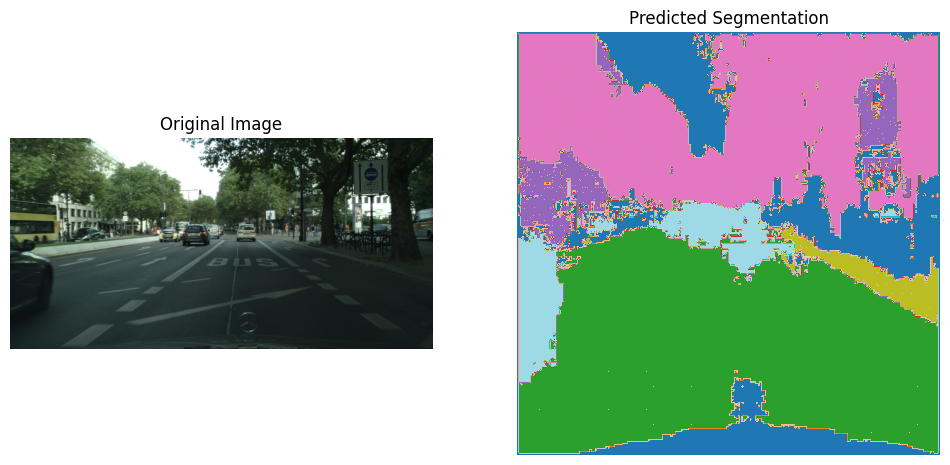

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Çıkışı CPU'ya taşı ve numpy array'e dönüştür
output_classes_np = output_classes.cpu().numpy()

# Görüntüyü ve model çıktısını görselleştir
plt.figure(figsize=(12, 6))

# Orijinal görüntü
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Modelin segmentasyon çıktısı
plt.subplot(1, 2, 2)
plt.imshow(output_classes_np, cmap="tab20")  # Sınıflar için renkli harita
plt.title("Predicted Segmentation")
plt.axis("off")

plt.show()
